In [1]:
#Modules needed

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#test
from sklearn.preprocessing import OneHotEncoder

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('float_format', lambda x: '{:.3f}'.format(x))



In [3]:
#Importing Power Generation & Weather Sensor Data which we will have to get through API's i guess...
#Still not sure how to though...

#Btw this is plant generation data

#generation_data = pd.read_csv('C:/Users/victo/OneDrive - University of Botswana/Desktop/SOLAR PREDICTION/Plant_2_Generation_Data.csv/Plant_2_Generation_Data.csv')

from google.colab import files
uploaded = files.upload()
#generation_data = pd.read_csv(uploaded)
#generation_data = uploaded

generation_data = next(iter(uploaded))
generation_data = pd.read_csv(generation_data)



Saving Plant_2_Generation_Data.csv to Plant_2_Generation_Data.csv


In [4]:
#this is weather data

from google.colab import files
uploaded2 = files.upload()

#weather_data = pd.read_csv(uploaded2)
#weather_data = uploaded2


weather_data = next(iter(uploaded2))
weather_data = pd.read_csv(weather_data)

Saving Plant_2_Weather_Sensor_Data.csv to Plant_2_Weather_Sensor_Data.csv


In [5]:
#random sample of plant generation data don forget
#We dont need the plant ID Shit and the source key

generation_data.sample(5)

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
20709  26/05/2020 01:30   4136001  LlT2YUhhzqhg5Sw     0.000     0.000   
65603  17/06/2020 00:00   4136001  q49J1IKaHRwDQnt     0.000     0.000   
7640   18/05/2020 15:00   4136001  LlT2YUhhzqhg5Sw     0.000     0.000   
59646  14/06/2020 04:30   4136001  4UPUqMRk7TRMgml     0.000     0.000   
59600  14/06/2020 03:45   4136001  xMbIugepa2P7lBB     0.000     0.000   

       DAILY_YIELD   TOTAL_YIELD  
20709        0.000 282663607.000  
65603      703.467    516601.000  
7640      3753.000 282620056.000  
59646     6289.000   2639150.000  
59600     2950.000 106872880.000

In [6]:
#And this 1 is the weather data sample
#We dont really need need the source key column, and the plant column so drop it

weather_data.sample(5)

DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
1186  27/05/2020 09:00   4136001  iq8k7ZNt4Mwm3w0               29.510   
1472  30/05/2020 08:45   4136001  iq8k7ZNt4Mwm3w0               25.788   
874   24/05/2020 03:00   4136001  iq8k7ZNt4Mwm3w0               25.819   
1181  27/05/2020 07:45   4136001  iq8k7ZNt4Mwm3w0               27.601   
2338  08/06/2020 09:45   4136001  iq8k7ZNt4Mwm3w0               29.463   

      MODULE_TEMPERATURE  IRRADIATION  
1186              42.324        0.610  
1472              28.674        0.215  
874               25.573        0.000  
1181              33.841        0.339  
2338              43.675        0.809

In [7]:
#Remember tht here we r converting the values in the 'DATE_TIME' column of the generation_data and weather_data dataframes to a datetime format.
# "day/month/year hour:minute"
#It will be easier to handle this whole shit

generation_data['DATE_TIME'] = pd.to_datetime(generation_data['DATE_TIME'],format = "%d/%m/%Y %H:%M")
weather_data['DATE_TIME'] = pd.to_datetime(weather_data['DATE_TIME'],format = "%d/%m/%Y %H:%M")

In [8]:
# Merge the weather detail and the plant data based on the dates
# we are also dropping the plumped ID and source key columns cause we don't need them
#"day/month/year hour:minute"

df_solar = pd.merge(generation_data.drop(columns = ['PLANT_ID']), weather_data.drop(columns = ['PLANT_ID', 'SOURCE_KEY']), on='DATE_TIME')

#Sample
df_solar.sample(5).style.background_gradient(cmap='cool')

In [9]:
# adding separate time and date columns
df_solar["DATE"] = pd.to_datetime(df_solar["DATE_TIME"]).dt.date
df_solar["TIME"] = pd.to_datetime(df_solar["DATE_TIME"]).dt.time
df_solar['DAY'] = pd.to_datetime(df_solar['DATE_TIME']).dt.day
df_solar['MONTH'] = pd.to_datetime(df_solar['DATE_TIME']).dt.month
df_solar['WEEK'] = pd.to_datetime(df_solar['DATE_TIME']).dt.week


# add hours and minutes for ml models
df_solar['HOURS'] = pd.to_datetime(df_solar['TIME'],format='%H:%M:%S').dt.hour
df_solar['MINUTES'] = pd.to_datetime(df_solar['TIME'],format='%H:%M:%S').dt.minute
df_solar['TOTAL MINUTES PASS'] = df_solar['MINUTES'] + df_solar['HOURS']*60

# add date as string column
df_solar["DATE_STRING"] = df_solar["DATE"].astype(str) # add column with date as string
df_solar["HOURS"] = df_solar["HOURS"].astype(str)
df_solar["TIME"] = df_solar["TIME"].astype(str)

df_solar.head(5)

DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD    TOTAL_YIELD  \
0 2020-05-15  4UPUqMRk7TRMgml     0.000     0.000     9425.000    2429011.000   
1 2020-05-15  81aHJ1q11NBPMrL     0.000     0.000        0.000 1215278736.000   
2 2020-05-15  9kRcWv60rDACzjR     0.000     0.000     3075.333 2247719577.000   
3 2020-05-15  Et9kgGMDl729KT4     0.000     0.000      269.933    1704250.000   
4 2020-05-15  IQ2d7wF4YD8zU1Q     0.000     0.000     3177.000   19941526.000   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION        DATE      TIME  \
0               27.005              25.061        0.000  2020-05-15  00:00:00   
1               27.005              25.061        0.000  2020-05-15  00:00:00   
2               27.005              25.061        0.000  2020-05-15  00:00:00   
3               27.005              25.061        0.000  2020-05-15  00:00:00   
4               27.005              25.061        0.000  2020-05-15  00:00:00   

   DAY  MONTH  WEEK HOURS  MINUTES  TOTAL MINUTES PASS DATE_STRING  
0   15      5    20     0        0                   0  2020-05-15  
1   15      5    20     0        0                   0  2020-05-15  
2   15      5    20     0        0                   0  2020-05-15  
3   15      5    20     0        0                   0  2020-05-15  
4   15      5    20     0        0                   0  2020-05-15

In [10]:
df_solar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67698 entries, 0 to 67697
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            67698 non-null  datetime64[ns]
 1   SOURCE_KEY           67698 non-null  object        
 2   DC_POWER             67698 non-null  float64       
 3   AC_POWER             67698 non-null  float64       
 4   DAILY_YIELD          67698 non-null  float64       
 5   TOTAL_YIELD          67698 non-null  float64       
 6   AMBIENT_TEMPERATURE  67698 non-null  float64       
 7   MODULE_TEMPERATURE   67698 non-null  float64       
 8   IRRADIATION          67698 non-null  float64       
 9   DATE                 67698 non-null  object        
 10  TIME                 67698 non-null  object        
 11  DAY                  67698 non-null  int64         
 12  MONTH                67698 non-null  int64         
 13  WEEK                 67698 non-

In [11]:
df_solar.isnull().sum()

DATE_TIME              0
SOURCE_KEY             0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
DATE                   0
TIME                   0
DAY                    0
MONTH                  0
WEEK                   0
HOURS                  0
MINUTES                0
TOTAL MINUTES PASS     0
DATE_STRING            0
dtype: int64

In [12]:
#The statistical ques u need to see performance data
df_solar.describe().style.background_gradient(cmap='rainbow')


In [13]:

#Dont know what it does but it does label encoding on the 'SOURCE_KEY' column of a pandas DataFrame named df_solar.
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_solar['SOURCE_KEY_NUMBER'] = encoder.fit_transform(df_solar['SOURCE_KEY'])
df_solar.head()

DATE_TIME       SOURCE_KEY  DC_POWER  AC_POWER  DAILY_YIELD    TOTAL_YIELD  \
0 2020-05-15  4UPUqMRk7TRMgml     0.000     0.000     9425.000    2429011.000   
1 2020-05-15  81aHJ1q11NBPMrL     0.000     0.000        0.000 1215278736.000   
2 2020-05-15  9kRcWv60rDACzjR     0.000     0.000     3075.333 2247719577.000   
3 2020-05-15  Et9kgGMDl729KT4     0.000     0.000      269.933    1704250.000   
4 2020-05-15  IQ2d7wF4YD8zU1Q     0.000     0.000     3177.000   19941526.000   

   AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION        DATE      TIME  \
0               27.005              25.061        0.000  2020-05-15  00:00:00   
1               27.005              25.061        0.000  2020-05-15  00:00:00   
2               27.005              25.061        0.000  2020-05-15  00:00:00   
3               27.005              25.061        0.000  2020-05-15  00:00:00   
4               27.005              25.061        0.000  2020-05-15  00:00:00   

   DAY  MONTH  WEEK HOURS  MINUTES  TOTAL MINUTES PASS DATE_STRING  \
0   15      5    20     0        0                   0  2020-05-15   
1   15      5    20     0        0                   0  2020-05-15   
2   15      5    20     0        0                   0  2020-05-15   
3   15      5    20     0        0                   0  2020-05-15   
4   15      5    20     0        0                   0  2020-05-15   

   SOURCE_KEY_NUMBER  
0                  0  
1                  1  
2                  2  
3                  3  
4                  4

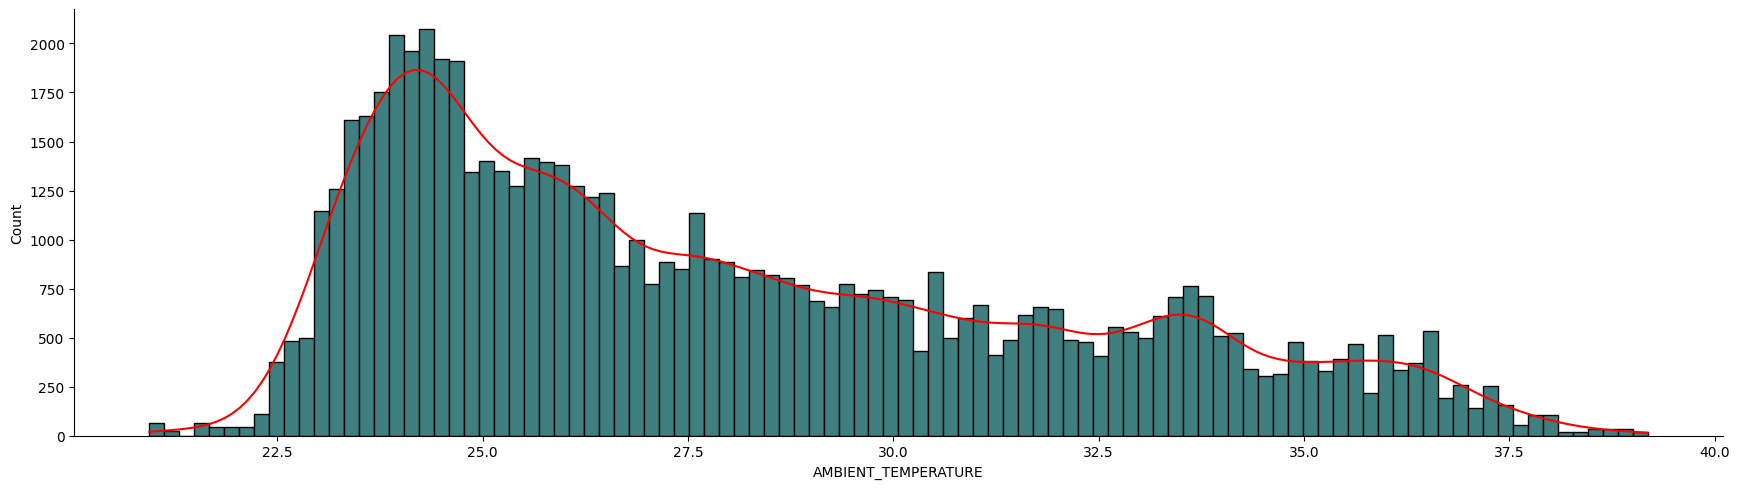

In [14]:
sns.displot(data=df_solar, x="AMBIENT_TEMPERATURE", kde=True, bins = 100,color = "red", facecolor = "#3F7F7F",height = 5, aspect = 3.5); # type: ignore

In [15]:
df_solar['DATE'].nunique()

34

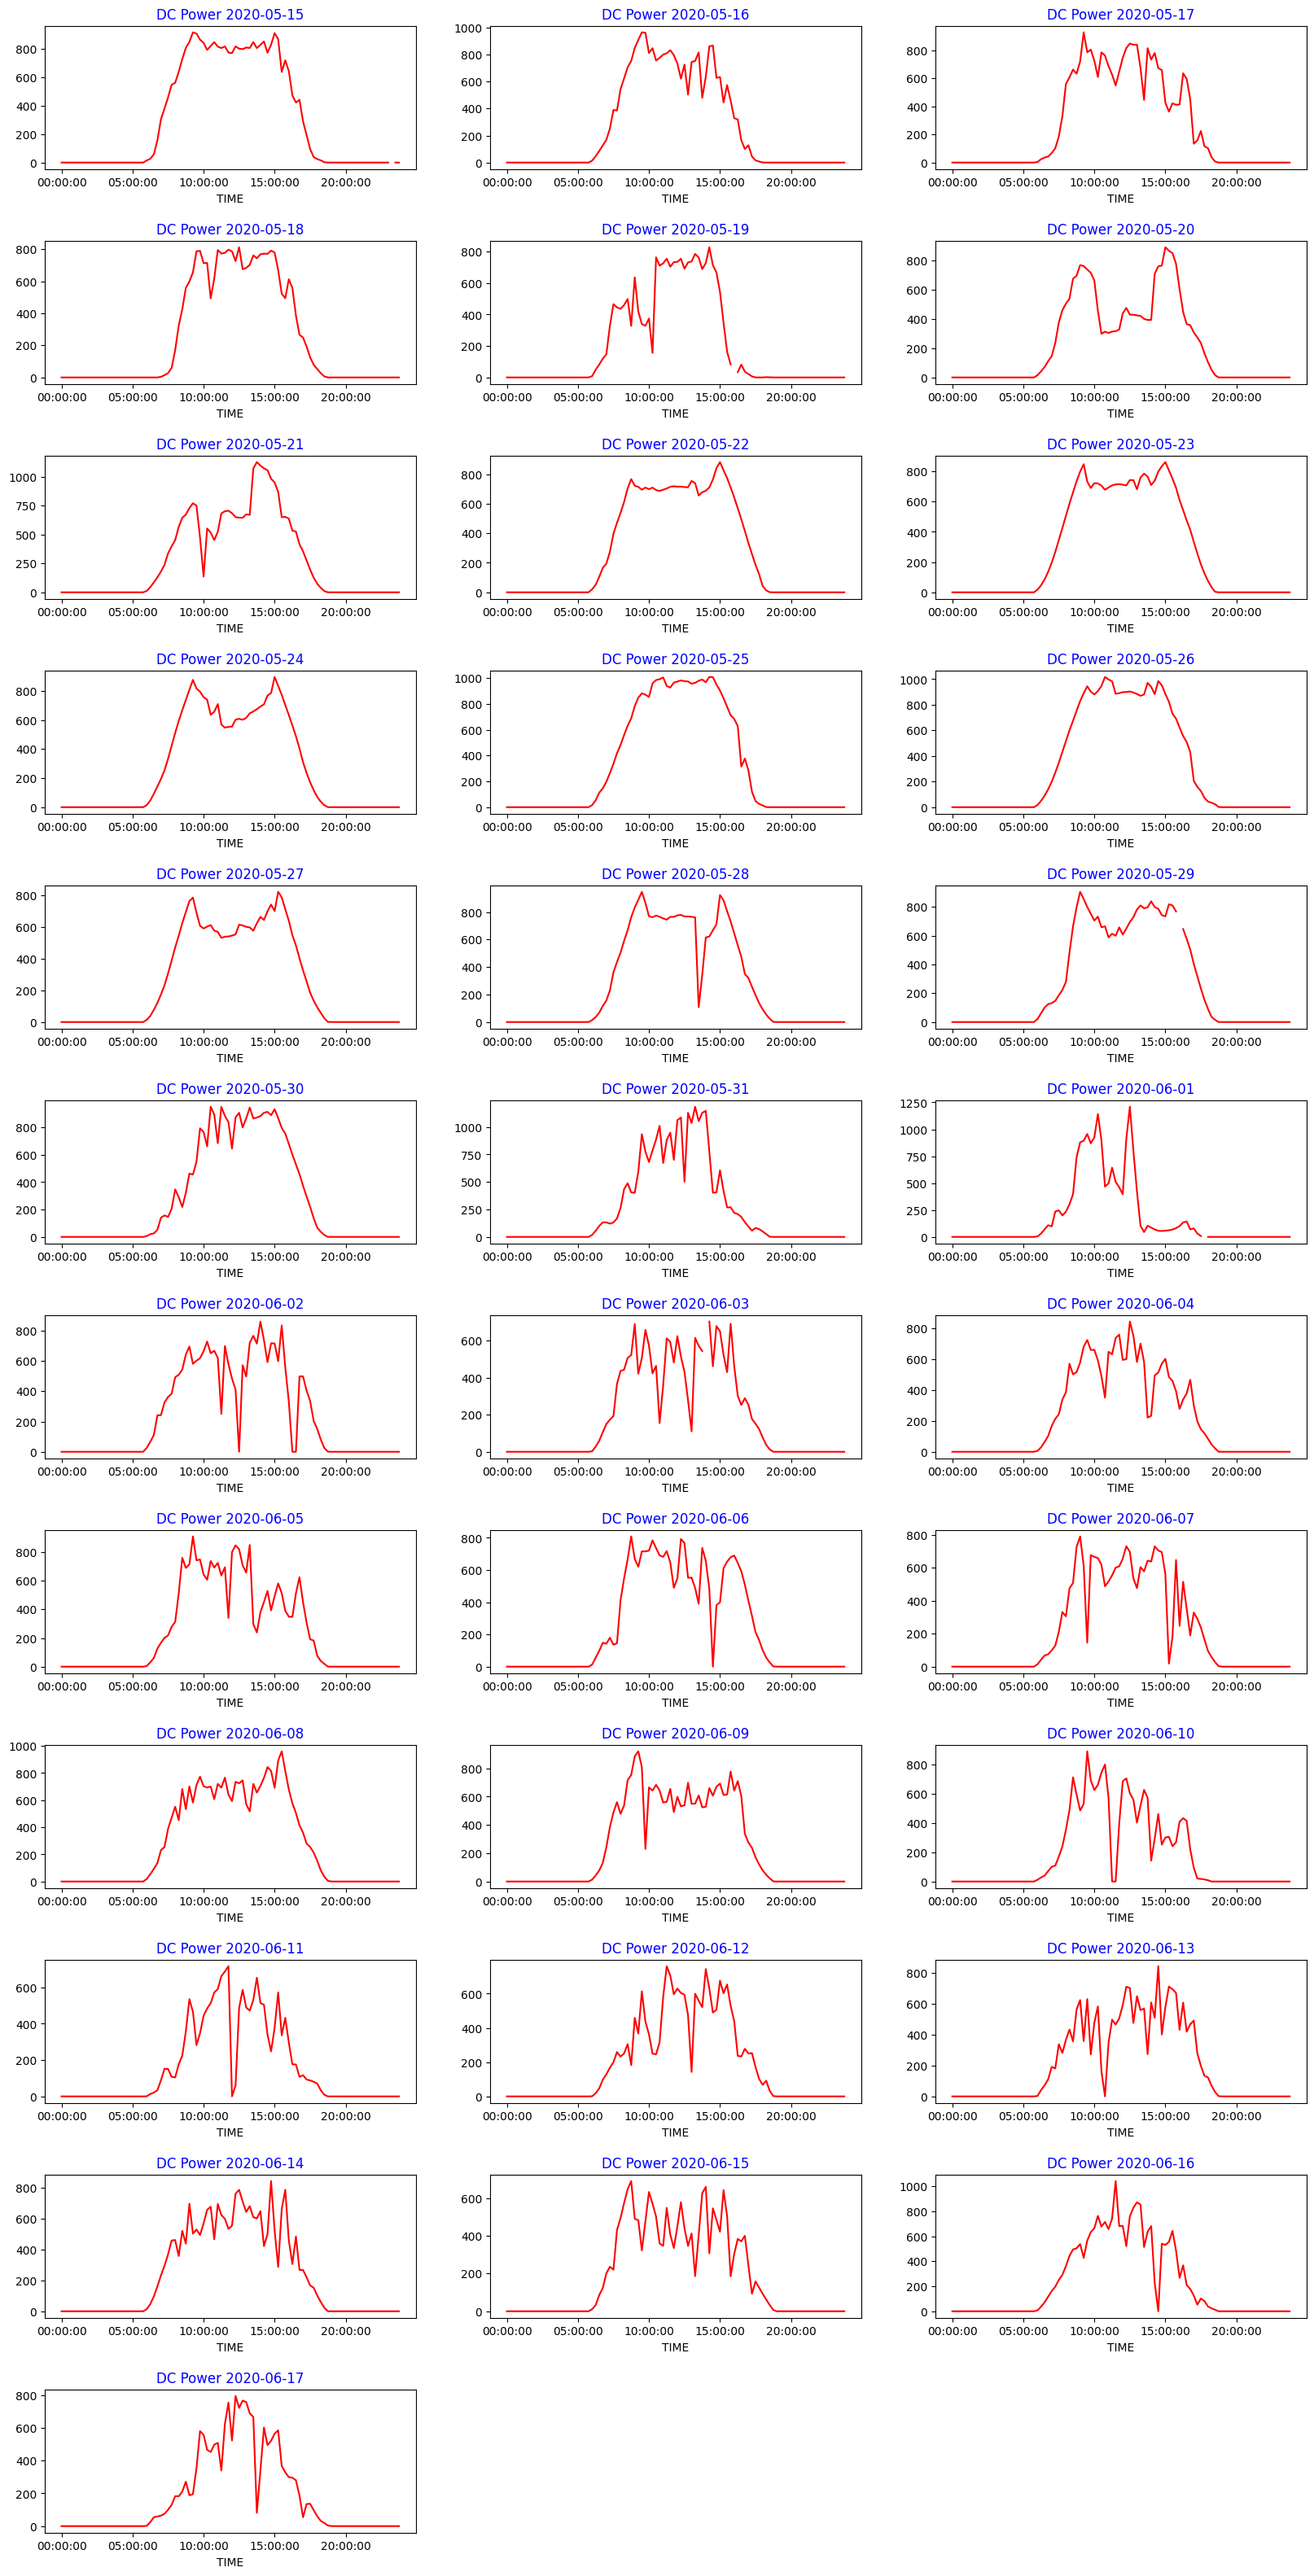

In [16]:
#Checking for faults and abnormalities in solar power generation

solar_dc = df_solar.pivot_table(values='DC_POWER', index='TIME', columns='DATE')

def Daywise_plot(data= None, row = None, col = None, title='DC Power'):
    cols = data.columns # take all column
    gp = plt.figure(figsize=(20,40))

    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols)+1):
        ax = gp.add_subplot(row,col, i)
        data[cols[i-1]].plot(ax=ax, color='red')
        ax.set_title('{} {}'.format(title, cols[i-1]),color='blue')

Daywise_plot(data=solar_dc, row=12, col=3)

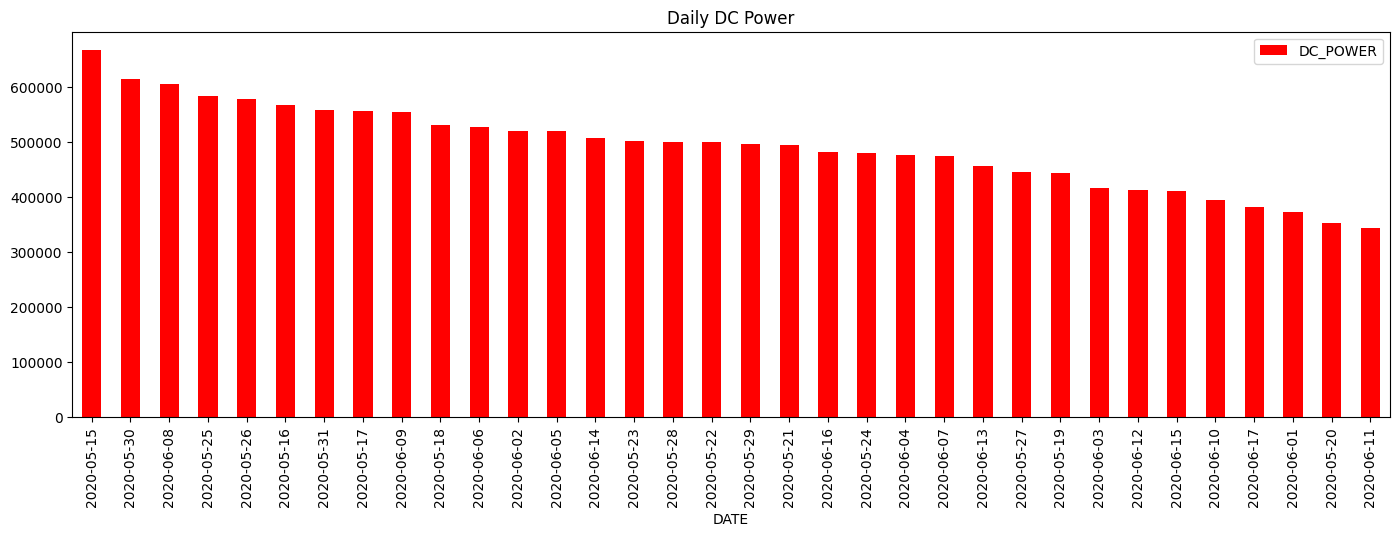

In [17]:
#DC power on a 34 day period

daily_dc = df_solar.groupby('DATE')['DC_POWER'].agg('sum')

ax = daily_dc.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='red')
plt.title('Daily DC Power')
plt.show()

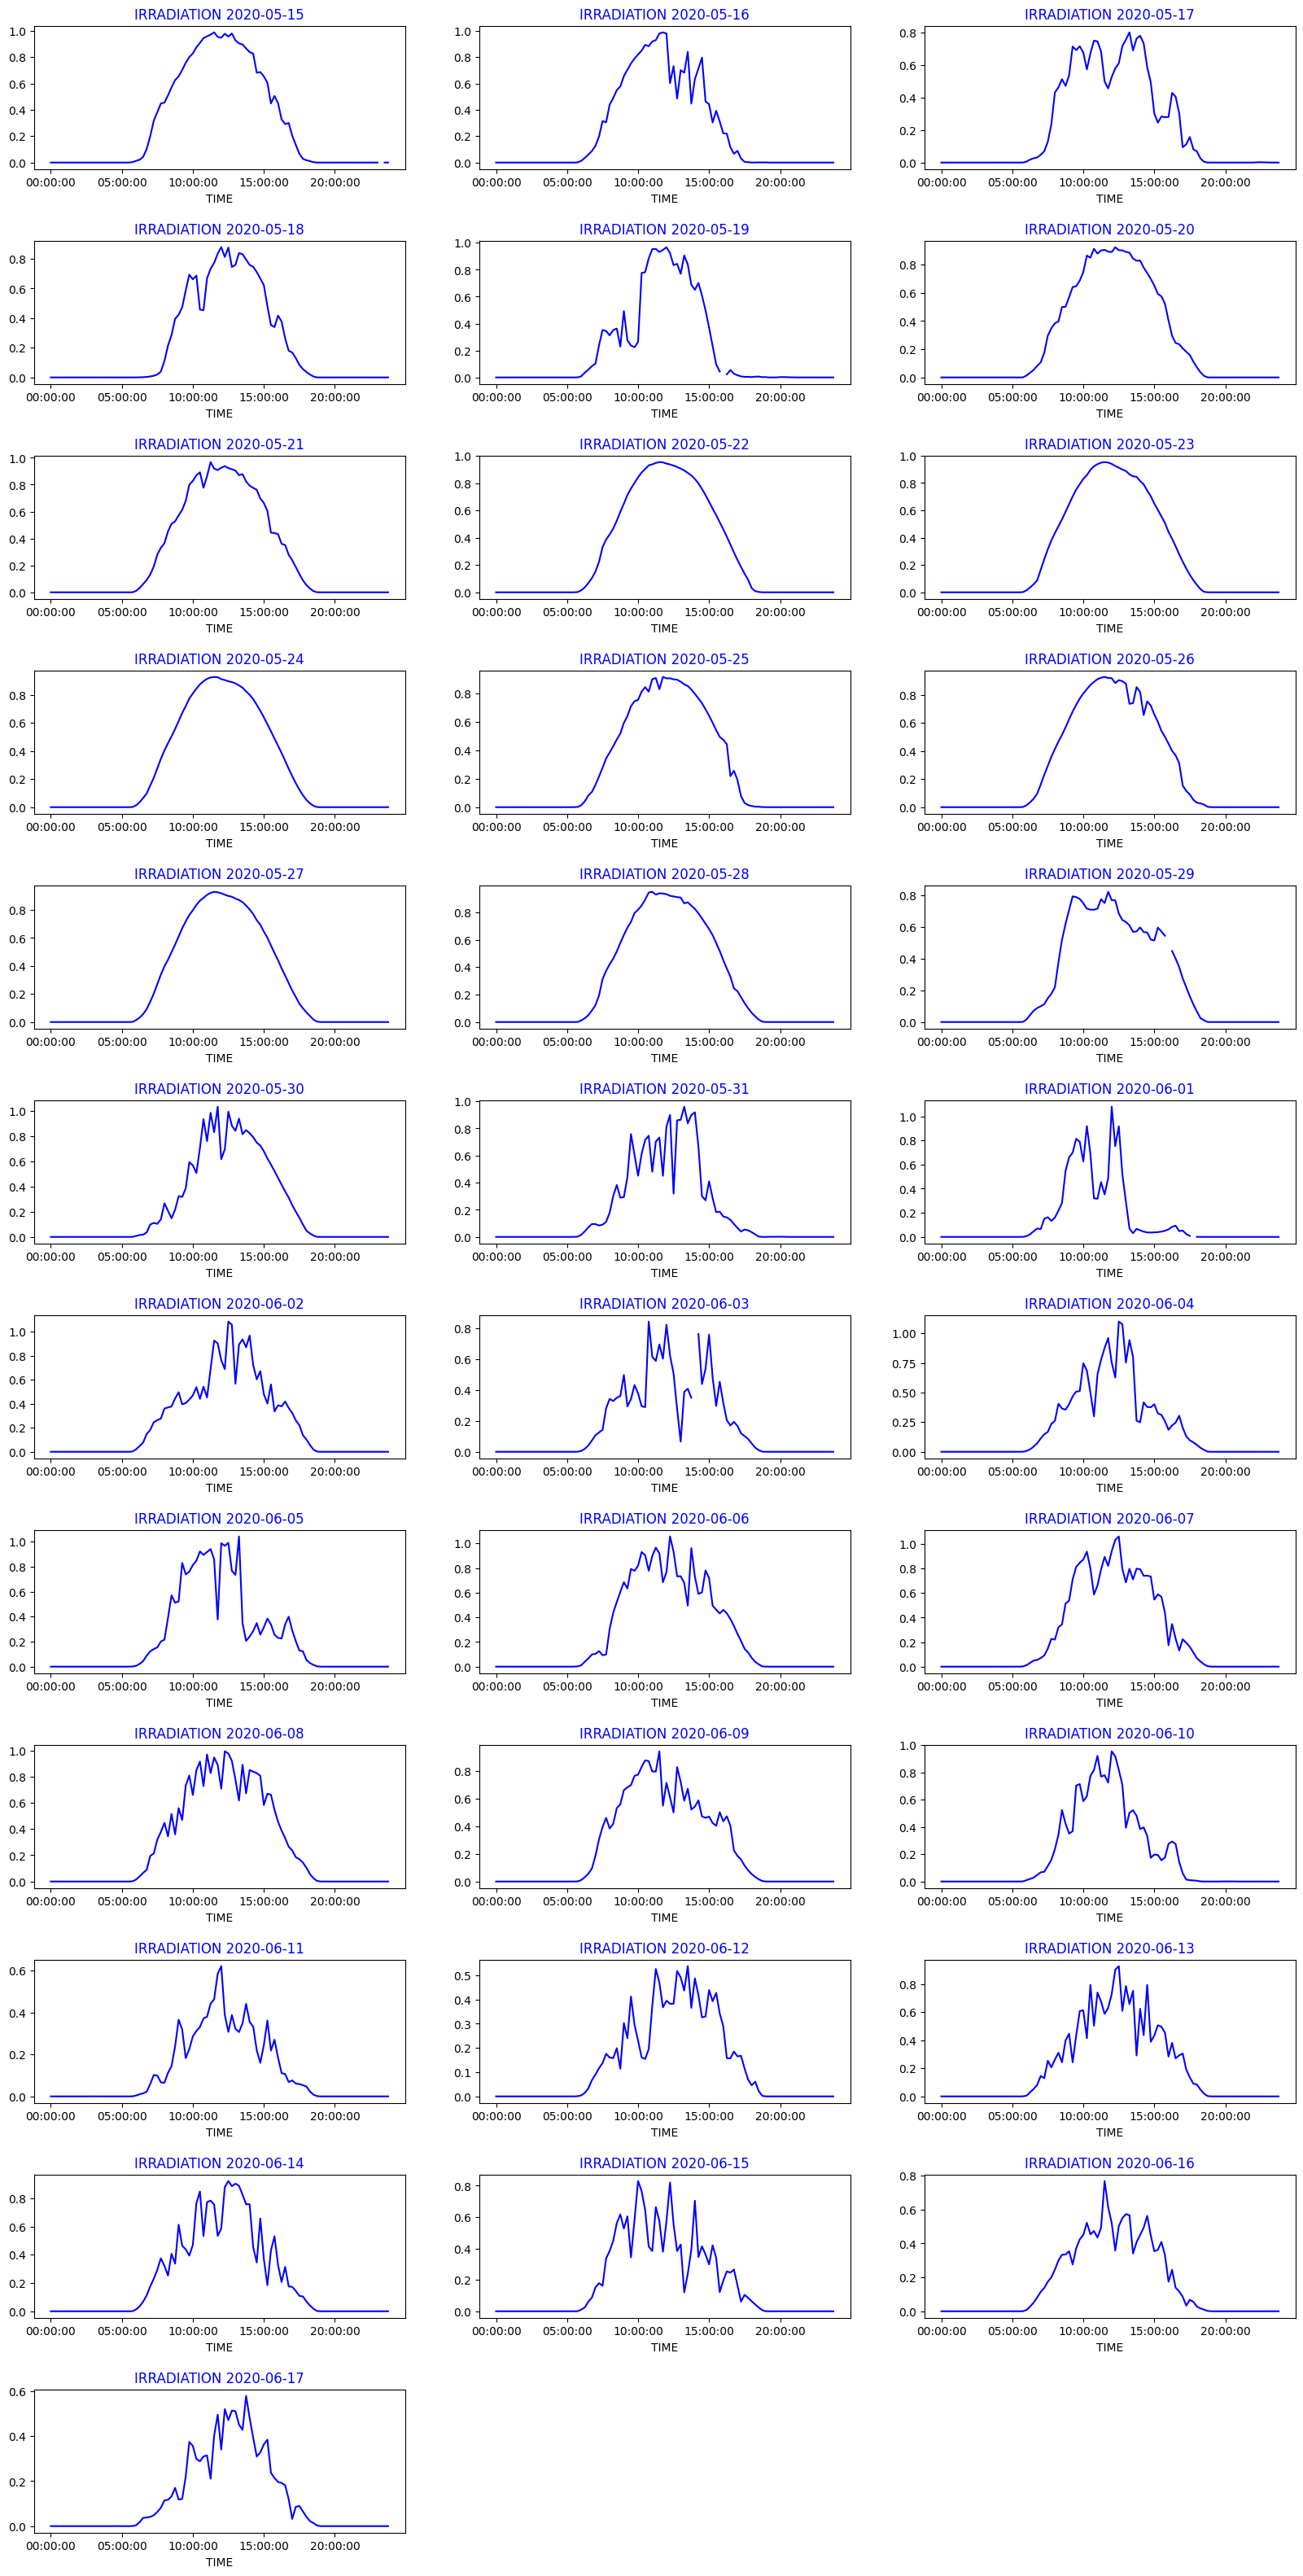

In [18]:
#dealing with solar IRRADIATION

solar_irradiation = df_solar.pivot_table(values='IRRADIATION', index='TIME', columns='DATE')

def Daywise_plot(data= None, row = None, col = None, title='IRRADIATION'):
    cols = data.columns # take all column
    gp = plt.figure(figsize=(20,40))

    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols)+1):
        ax = gp.add_subplot(row,col, i)
        data[cols[i-1]].plot(ax=ax, color='blue')
        ax.set_title('{} {}'.format(title, cols[i-1]),color='blue')

Daywise_plot(data=solar_irradiation, row=12, col=3)

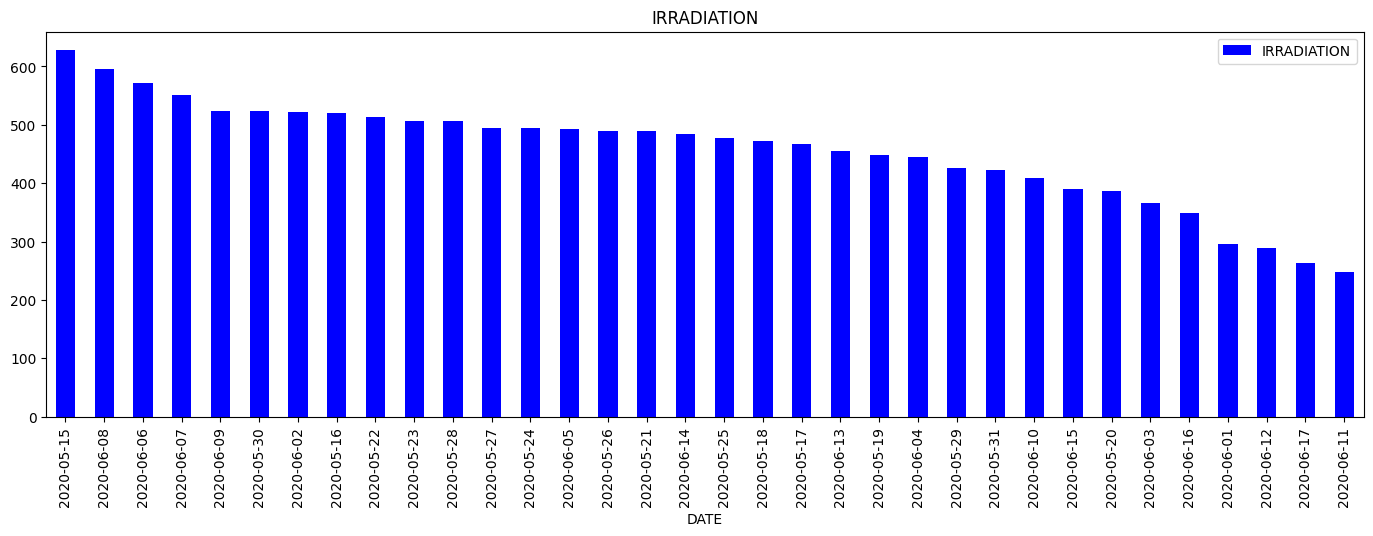

In [19]:
daily_irradiation = df_solar.groupby('DATE')['IRRADIATION'].agg('sum')

daily_irradiation.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='blue')
plt.title('IRRADIATION')
plt.show()

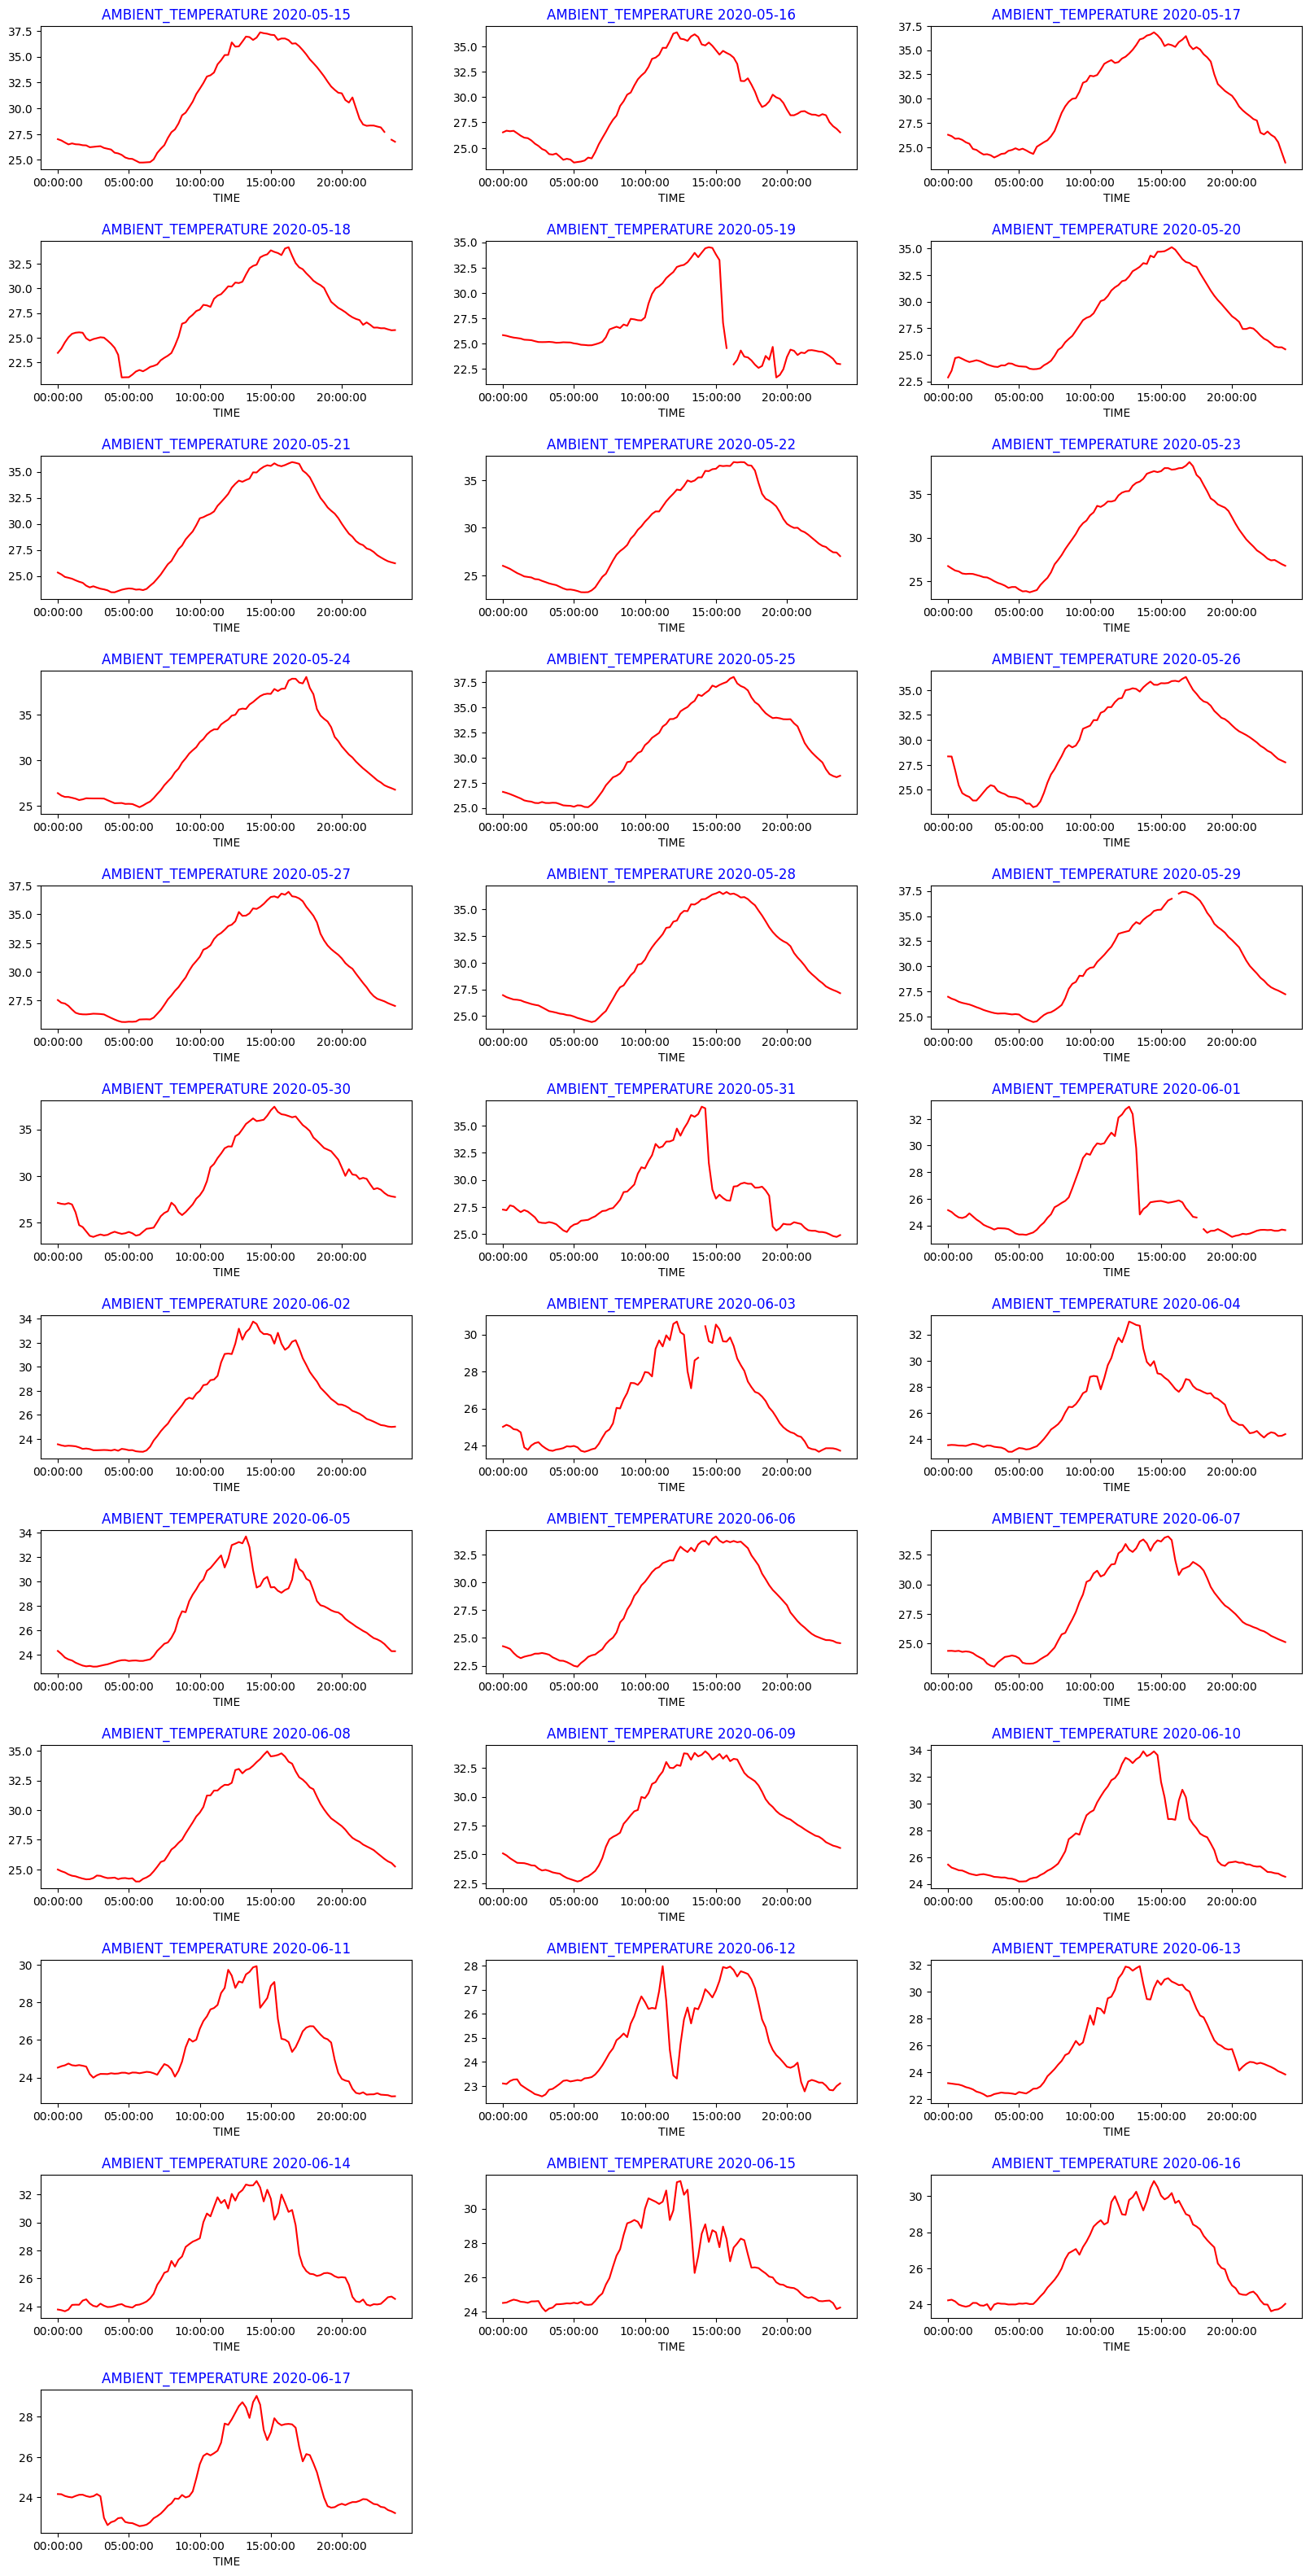

In [20]:
#This time for AMBIENT TEMPERATURE

solar_ambiant_temp = df_solar.pivot_table(values='AMBIENT_TEMPERATURE', index='TIME', columns='DATE')

def Daywise_plot(data= None, row = None, col = None, title='AMBIENT_TEMPERATURE'):
    cols = data.columns # take all column
    gp = plt.figure(figsize=(20,40))

    gp.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1, len(cols)+1):
        ax = gp.add_subplot(row,col, i)
        data[cols[i-1]].plot(ax=ax, color='RED')
        ax.set_title('{} {}'.format(title, cols[i-1]),color='blue')

Daywise_plot(data=solar_ambiant_temp, row=12, col=3)

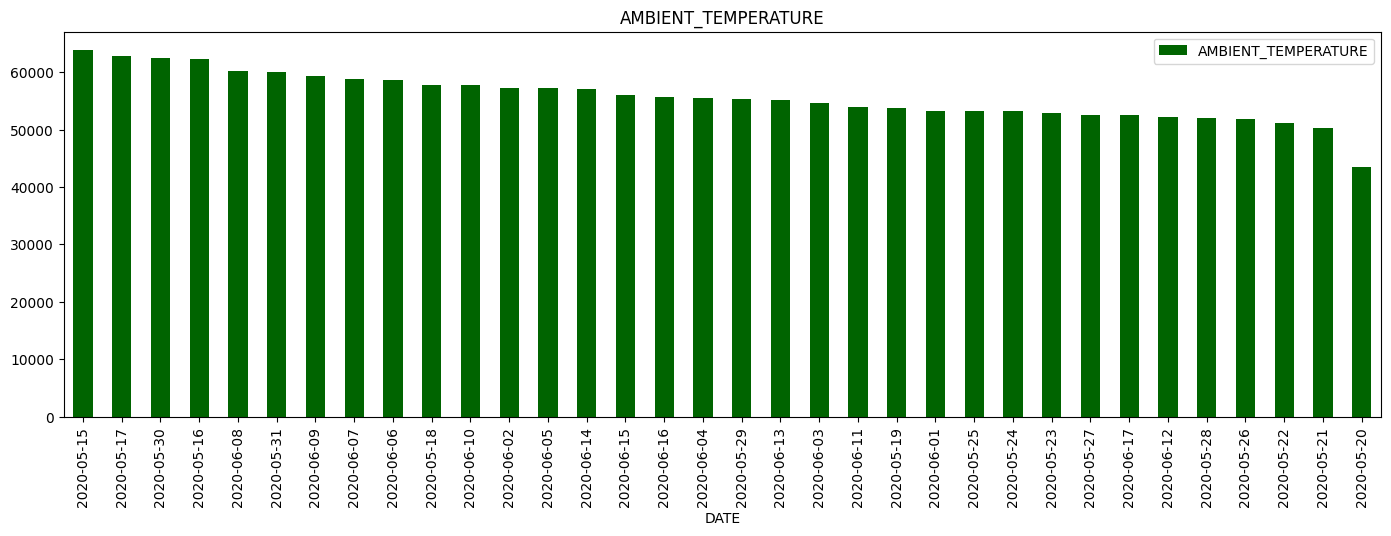

In [21]:
daily_ambient_temp = df_solar.groupby('DATE')['AMBIENT_TEMPERATURE'].agg('sum')

daily_ambient_temp.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='darkgreen')
plt.title('AMBIENT_TEMPERATURE')
plt.show()

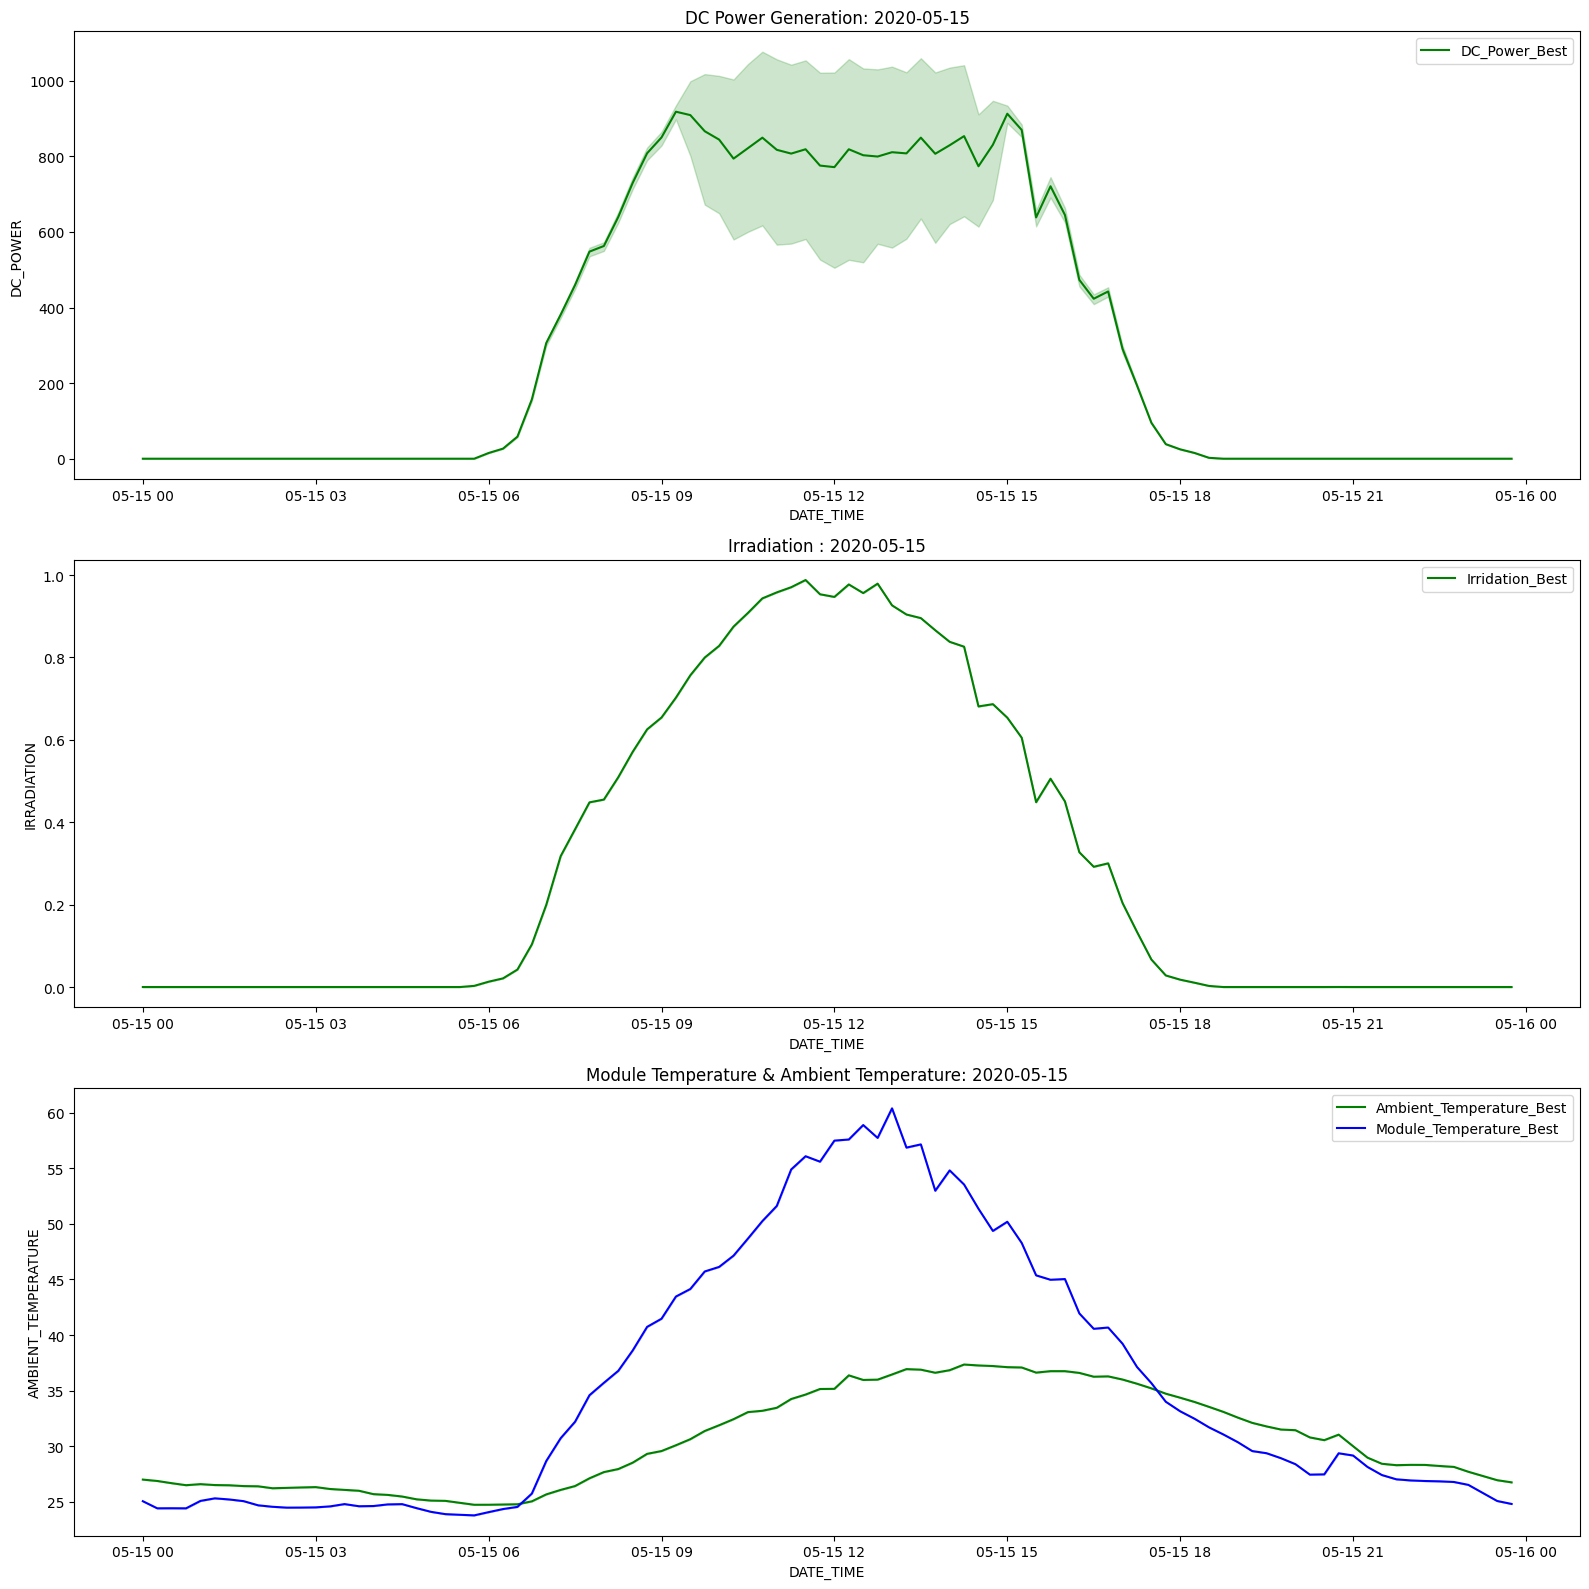

In [22]:
#This code is creating a figure with three subplots, where each subplot
# shows a line plot of a different variable over a specific date range.
# The variables being plotted are DC_POWER, IRRADIATION, AMBIENT_TEMPERATURE,
# and MODULE_TEMPERATURE, which are stored in the pandas DataFrame df_sola

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(16,16))

date=["2020-05-15"]

sns.lineplot(x=df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, y=df_solar[df_solar["DATE_STRING"].isin(date)].DC_POWER, label="DC_Power_Best", color='green', ax=axs[0])
axs[0].set_title("DC Power Generation: {}".format(date[0]))

sns.lineplot(x=df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, y=df_solar[df_solar["DATE_STRING"].isin(date)].IRRADIATION, label="Irridation_Best", color='green', ax=axs[1])
axs[1].set_title("Irradiation : {}".format(date[0]))

sns.lineplot(x=df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, y=df_solar[df_solar["DATE_STRING"].isin(date)].AMBIENT_TEMPERATURE, label="Ambient_Temperature_Best", color='green', ax=axs[2])
sns.lineplot(x=df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, y=df_solar[df_solar["DATE_STRING"].isin(date)].MODULE_TEMPERATURE, label="Module_Temperature_Best", color='blue', ax=axs[2])
axs[2].set_title("Module Temperature & Ambient Temperature: {}".format(date[0]))

plt.tight_layout()
plt.show()



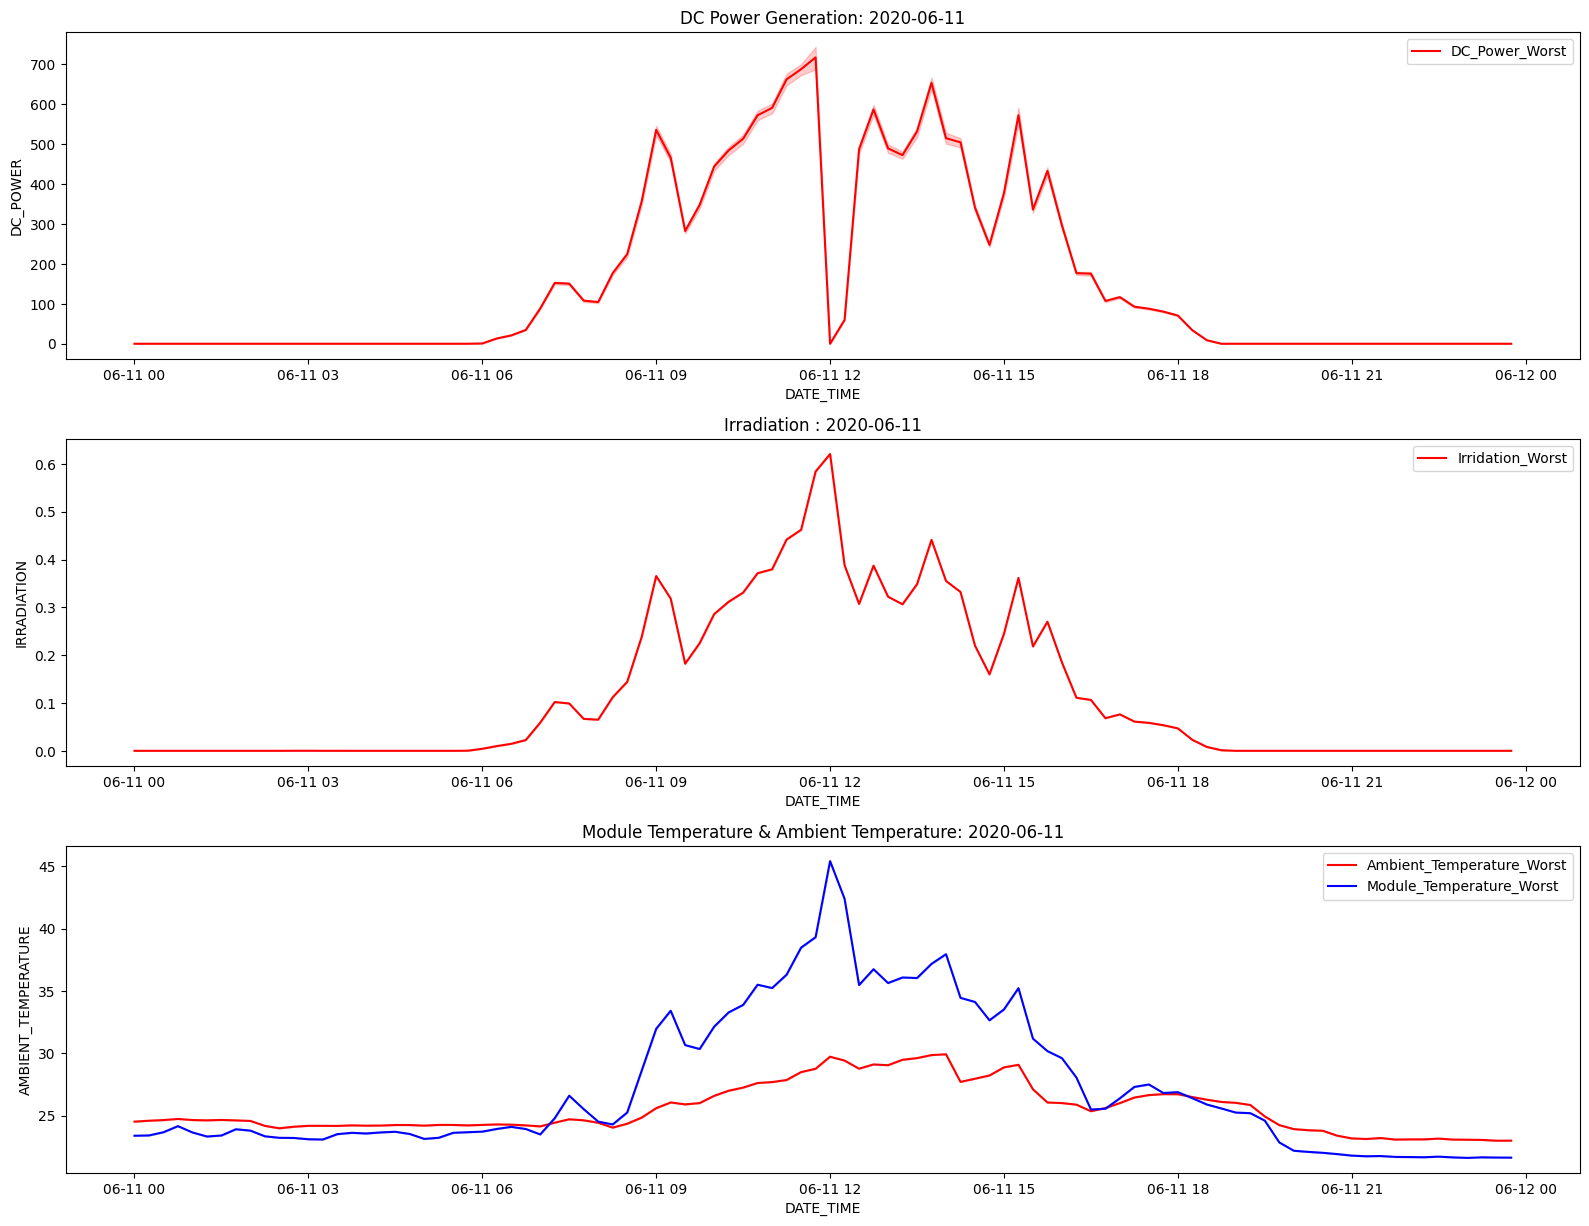

In [23]:
date=["2020-06-11"]
plt.figure(figsize=(16,16))

plt.subplot(411)
sns.lineplot(x=df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, y=df_solar[df_solar["DATE_STRING"].isin(date)].DC_POWER, label="DC_Power_Worst",color='red')
plt.title("DC Power Generation: {}" .format(date[0]))

plt.subplot(412)
sns.lineplot(x=df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, y=df_solar[df_solar["DATE_STRING"].isin(date)].IRRADIATION, label="Irridation_Worst",color='red')
plt.title("Irradiation : {}" .format(date[0]))

plt.subplot(413)
sns.lineplot(x=df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, y=df_solar[df_solar["DATE_STRING"].isin(date)].AMBIENT_TEMPERATURE, label="Ambient_Temperature_Worst",color='red')
sns.lineplot(x=df_solar[df_solar["DATE_STRING"].isin(date)].DATE_TIME, y=df_solar[df_solar["DATE_STRING"].isin(date)].MODULE_TEMPERATURE, label="Module_Temperature_Worst",color='blue')
plt.title("Module Temperature & Ambient Temperature: {}" .format(date[0]))

plt.tight_layout()
plt.show()


<Axes: >

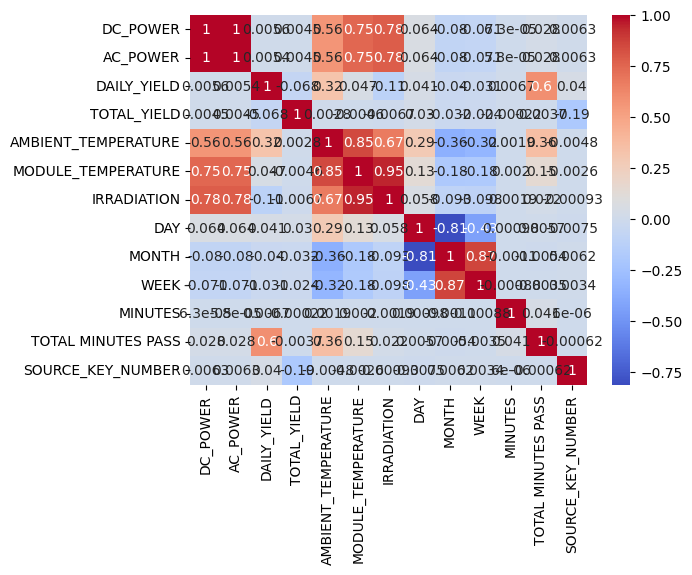

In [24]:
corr = df_solar.corr()
sns.heatmap(corr, cmap="coolwarm", annot=True)


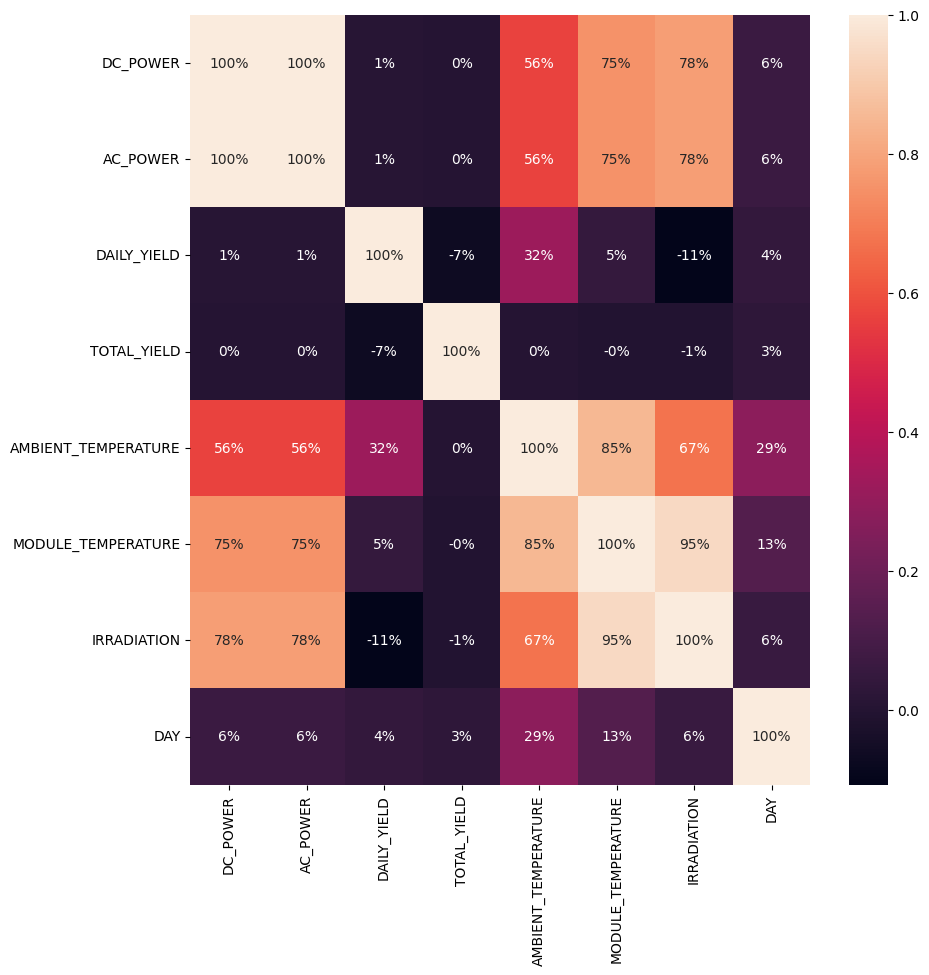

In [25]:
# Visualation of the correlation table above
plt.figure(figsize = (10 , 10))

# Create a correlation matrix for the relevant columns
corr_matrix = df_solar.iloc[:, 1:12].corr()

# Create a heatmap using seaborn
sns.heatmap(corr_matrix, annot=True, fmt=".0%")

# Display the heatmap
plt.show()

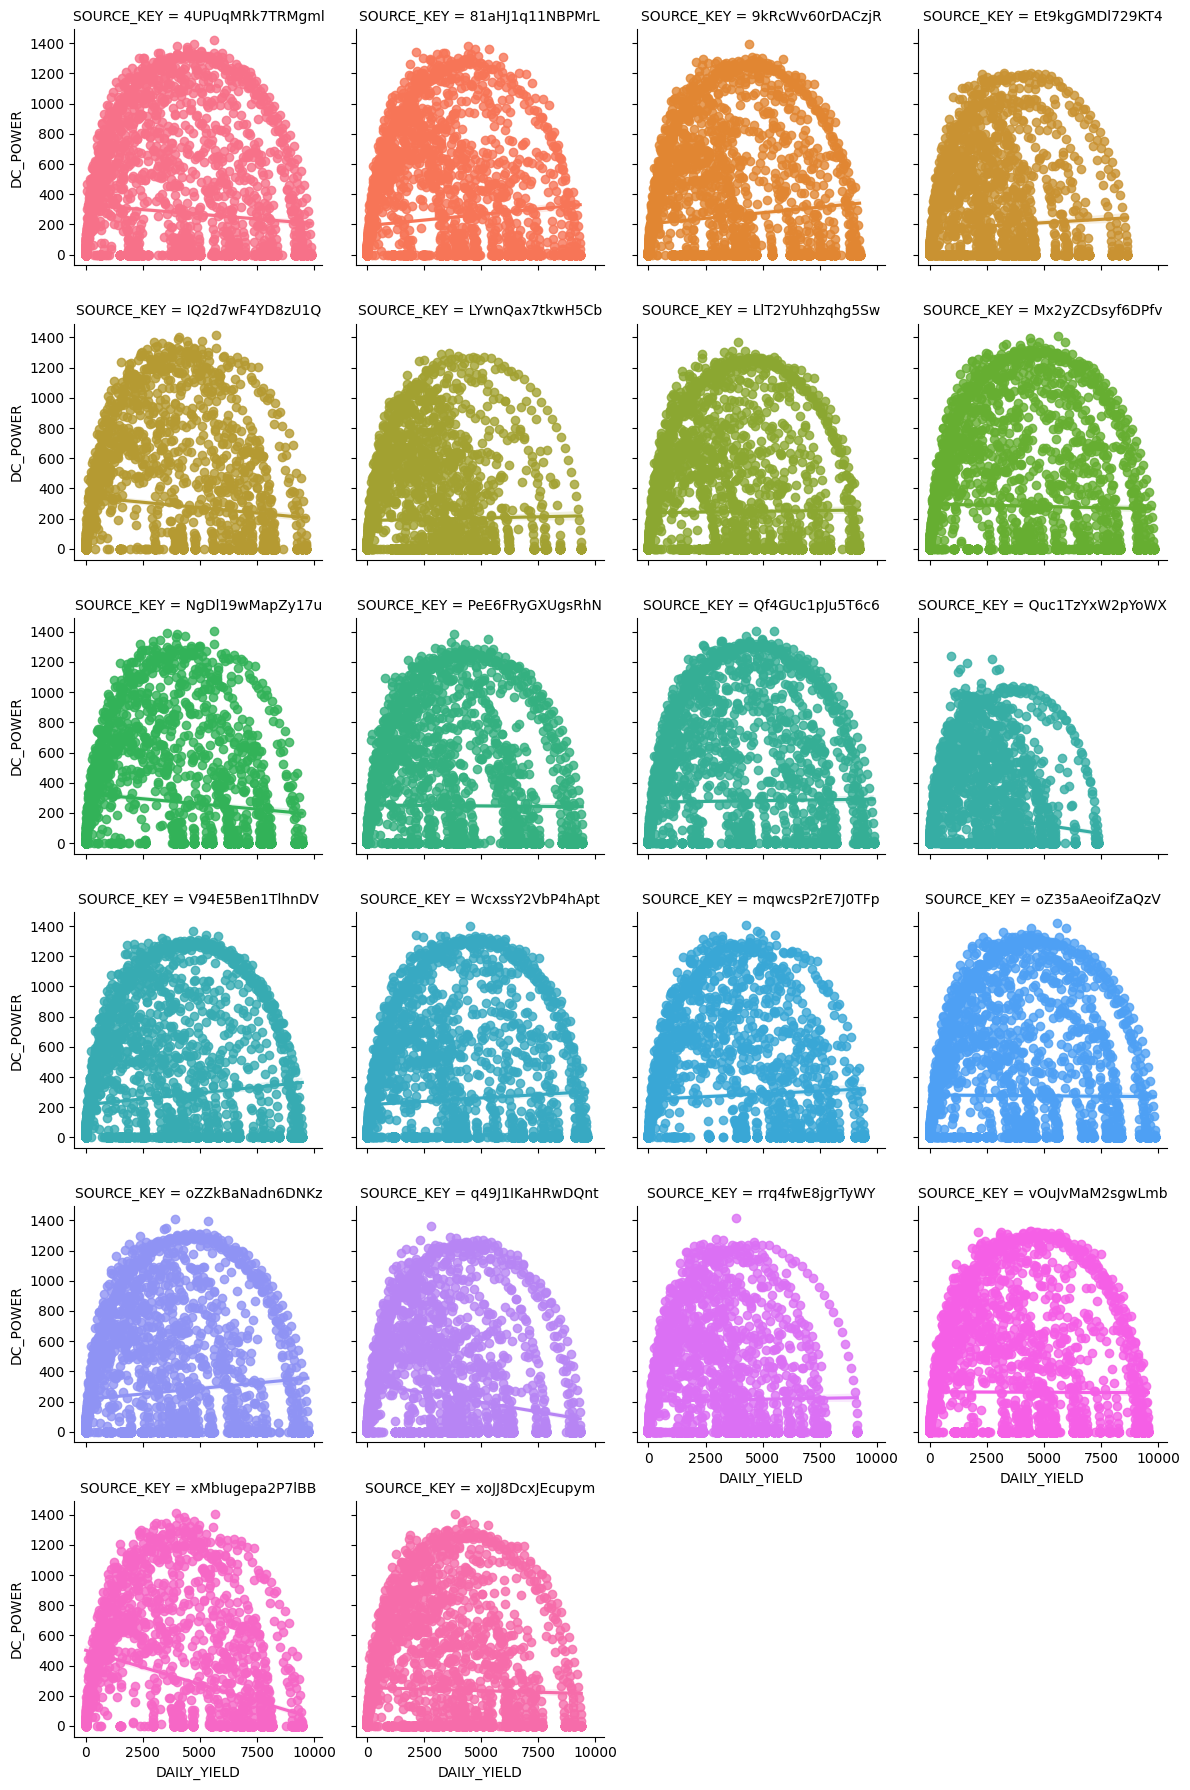

In [26]:
sns.lmplot(y="DC_POWER",x="DAILY_YIELD",hue="SOURCE_KEY",col="SOURCE_KEY",height=3,col_wrap=4,data=df_solar,fit_reg=True);

In [27]:
#EFFICIENCY VALUES
solar_dc_power = df_solar[df_solar['DC_POWER'] > 0]['DC_POWER'].values
solar_ac_power = df_solar[df_solar['AC_POWER'] > 0]['AC_POWER'].values

In [28]:
solar_plant_eff = (np.max(solar_ac_power)/np.max(solar_dc_power ))*100
print(f"Power ratio AC/DC (Efficiency) of Solar Power Plant:  {solar_plant_eff:0.3f} %")

print("Solar AC Power: ", np.max(solar_ac_power)) # type: ignore
print("Solar DC Power: ", np.max(solar_dc_power)) # type: ignore

Power ratio AC/DC (Efficiency) of Solar Power Plant:  97.501 %
Solar AC Power:  1385.42
Solar DC Power:  1420.933333


In [29]:
#filters out any values of AC_POWER that are less than or equal to 0, and only keeps the positive values in a new list called AC_list.
# The length of the AC_list indicates the number of positive AC_POWER values in the DataFrame.

AC_list=[]
for i in df_solar['AC_POWER']:
    if i>0:
        AC_list.append(i)
AC_list
#AC_list.sort()
#AC_list.reverse()
len(AC_list)

32036

In [30]:
#Here we take all nonzero DC values and plot them on histogram
DC_list=[]
for i in df_solar['DC_POWER']:
    if i>0:
        DC_list.append(i)
DC_list
DC_list.sort()
DC_list.reverse()
len(DC_list)

32036

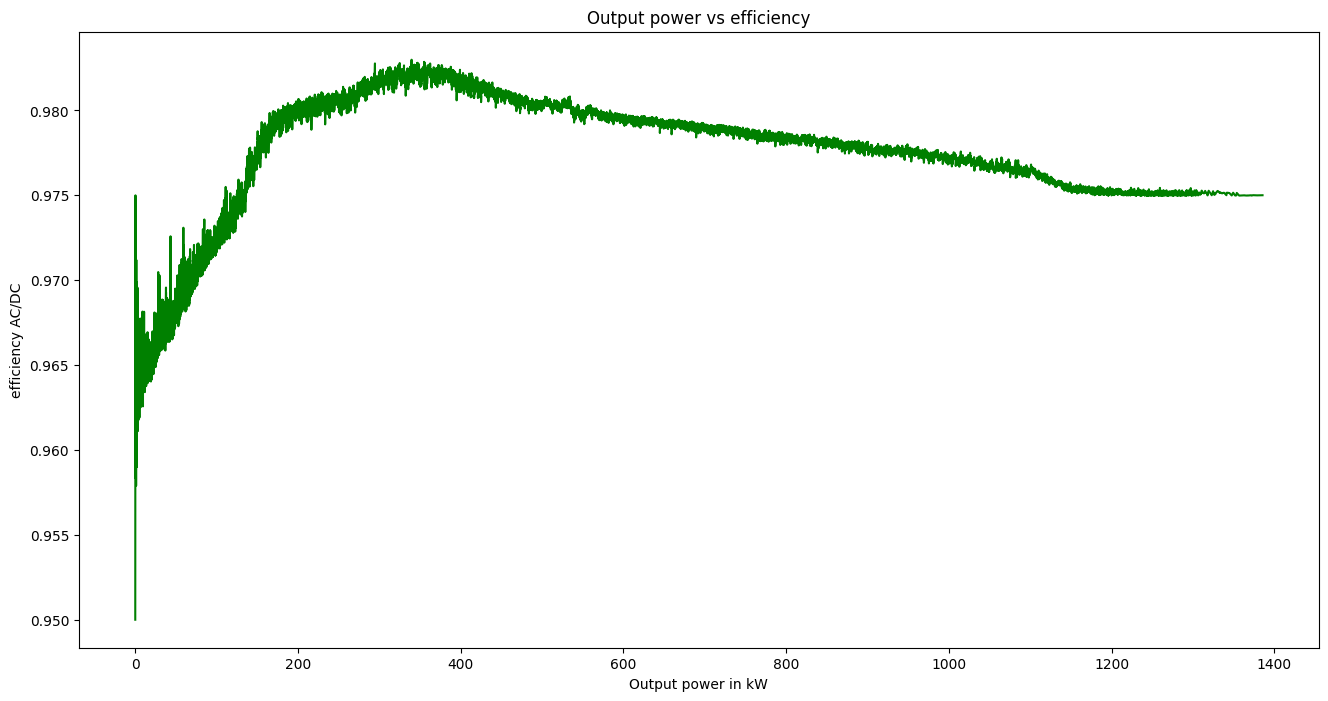

In [31]:
#plot of the efficiency of the AC to DC conversion versus the output power of a solar panel system
#Overall, this code is used to visualize the efficiency of a
# solar panel system by plotting the efficiency of AC to DC conversion versus the output power.

plt.figure(figsize=(16,8))
AC_list.sort()
DC_list.sort()
#print(DC_list)
#DC_list.sort
#res = [i / 10 for i in AC_list]
eff = [i/j for i,j in zip(AC_list,DC_list)]

plt.plot(AC_list,eff,color='green')
plt.xlabel('Output power in kW')
plt.ylabel('efficiency AC/DC')
plt.title('Output power vs efficiency');

In [85]:
# SOLAR POWER PREDICTIONS

from sklearn.model_selection import train_test_split
# Copy the solar DataFrame to df2
df2 = df_solar.copy()

# Define the features (X) and target variable (Y) for classification
X_cls = df2[['DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DC_POWER']]
Y_cls = df2['AC_POWER']

In [86]:
X_cls.head()

DAILY_YIELD    TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
0     9425.000    2429011.000               27.005              25.061   
1        0.000 1215278736.000               27.005              25.061   
2     3075.333 2247719577.000               27.005              25.061   
3      269.933    1704250.000               27.005              25.061   
4     3177.000   19941526.000               27.005              25.061   

   IRRADIATION  DC_POWER  
0        0.000     0.000  
1        0.000     0.000  
2        0.000     0.000  
3        0.000     0.000  
4        0.000     0.000

In [87]:
Y_cls.head()

0   0.000
1   0.000
2   0.000
3   0.000
4   0.000
Name: AC_POWER, dtype: float64

In [88]:
#Alright we are done sorting and taking samples of data
#this where we get dirty with analizing the data


#Split the data into independent (X) and dependent (Y) data sets
# Split the data into training and testing sets for classification


X_train_cls, X_test_cls, Y_train_cls, Y_test_cls = train_test_split(X_cls, Y_cls, test_size=0.2, random_state=42)


# Split the data into training and testing set


#type(X)
#Changed it to array to handle data better

In [89]:
#so here is where we train our model on the data we have
# I used 75% of the data to train it and 25% on Testing (just split data)


#ignore for now
#from sklearn.model_selection import train_test_split
#X_train , X_test, Y_train , Y_test = train_test_split(X, Y , test_size = 0.20 , random_state = 0)

In [90]:
#scaling the data (Feature scaling)
from sklearn.discriminant_analysis import StandardScaler
# Feature scaling for classification
sc = StandardScaler()
X_train_cls = sc.fit_transform(X_train_cls)
X_test_cls = sc.transform(X_test_cls)

In [91]:
#creating the models we need
# Import the required libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# Model training for classification
# Model training for regression
def train_regression_models(X_train_cls, Y_train_cls):
    # Linear Regression
    from sklearn.linear_model import LinearRegression
    linear_reg = LinearRegression()
    linear_reg.fit(X_train_cls, Y_train_cls)

    # Decision Tree Regression
    from sklearn.tree import DecisionTreeRegressor
    tree_reg = DecisionTreeRegressor(random_state=0)
    tree_reg.fit(X_train_cls, Y_train_cls)

    # Random Forest Regression
    from sklearn.ensemble import RandomForestRegressor
    forest_reg = RandomForestRegressor(n_estimators=30, random_state=0)
    forest_reg.fit(X_train_cls, Y_train_cls)

    # Print model R-squared scores based on the training data
    print('[0] Linear Regression R-squared:', linear_reg.score(X_train_cls, Y_train_cls))
    print('[1] Decision Tree Regression R-squared:', tree_reg.score(X_train_cls, Y_train_cls))
    print('[2] Random Forest Regression R-squared:', forest_reg.score(X_train_cls, Y_train_cls))

    return linear_reg, tree_reg, forest_reg



In [92]:
cls_models = train_regression_models(X_train_cls , Y_train_cls)

[0] Linear Regression R-squared: 0.9999934506616885
[1] Decision Tree Regression R-squared: 1.0
[2] Random Forest Regression R-squared: 0.9999997096018639


In [93]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid with reduced ranges
max_features_range = np.arange(1, 4, 1)  # Reduced range for max_features
n_estimators_range = np.arange(10, 100, 10)  # Reduced range for n_estimators
param_distributions = dict(max_features=max_features_range, n_estimators=n_estimators_range)

# Create the RandomForestRegressor
rf = RandomForestRegressor()

# Initialize RandomizedSearchCV with parallel processing and fewer iterations (n_iter)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                   n_iter=10, cv=5, n_jobs=-1)

# Fit the random search to the data
random_search.fit(X_train_cls, Y_train_cls)

print("The best parameters are %s with a score of %0.2f" % (random_search.best_params_, random_search.best_score_))

# Access the results
random_results = pd.concat([pd.DataFrame(random_search.cv_results_["params"]),
                          pd.DataFrame(random_search.cv_results_["mean_test_score"], columns=["Accuracy"])],
                         axis=1)

random_contour = random_results.groupby(['max_features', 'n_estimators']).mean().reset_index()
random_contour.columns = ['max_features', 'n_estimators', 'Accuracy']
random_pivot = random_contour.pivot('max_features', 'n_estimators')
random_results.head()


The best parameters are {'n_estimators': 90, 'max_features': 3} with a score of 1.00


n_estimators  max_features  Accuracy
0            10             2     1.000
1            80             1     0.998
2            60             3     1.000
3            10             3     1.000
4            50             1     0.998

In [94]:
import pandas as pd

grid_results = pd.concat([pd.DataFrame(random_search.cv_results_["params"]),pd.DataFrame(random_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
grid_results.head()

n_estimators  max_features  Accuracy
0            10             2     1.000
1            80             1     0.998
2            60             3     1.000
3            10             3     1.000
4            50             1     0.998

In [95]:
#Extract only the max features with the n_estimators, along with the accuracy score from the reults of the grid score
grid_contour = grid_results.groupby(['max_features','n_estimators']).mean()
grid_contour

Accuracy
max_features n_estimators          
1            40               0.998
             50               0.998
             80               0.998
2            10               1.000
             30               1.000
             60               1.000
3            10               1.000
             60               1.000
             80               1.000
             90               1.000

In [96]:
#Pivoting the data
grid_reset = grid_contour.reset_index()
grid_reset.columns = ['max_features', 'n_estimators', 'Accuracy']
grid_pivot = grid_reset.pivot('max_features', 'n_estimators')
grid_pivot

Accuracy                                    
n_estimators       10    30    40    50    60    80    90
max_features                                             
1                 NaN   NaN 0.998 0.998   NaN 0.998   NaN
2               1.000 1.000   NaN   NaN 1.000   NaN   NaN
3               1.000   NaN   NaN   NaN 1.000 1.000 1.000

In [97]:
# Extracting values
x = grid_pivot.columns.levels[1].values
y = grid_pivot.index.values
z = grid_pivot.values

In [98]:
x

array([10, 30, 40, 50, 60, 80, 90])

In [99]:
y

array([1, 2, 3])

In [100]:
z

array([[       nan,        nan, 0.99826398, 0.99835579,        nan,
        0.99844051,        nan],
       [0.99952004, 0.99981959,        nan,        nan, 0.99983346,
               nan,        nan],
       [0.99992977,        nan,        nan,        nan, 0.99997839,
        0.99997842, 0.99998018]])

In [101]:
# **2D Contour Plot**

import plotly.graph_objects as go

# X and Y axes labels
layout = go.Layout(
            xaxis=go.layout.XAxis(
              title=go.layout.xaxis.Title(
              text='n_estimators')
             ),
             yaxis=go.layout.YAxis(
              title=go.layout.yaxis.Title(
              text='max_features')
            ) )

fig = go.Figure(data = [go.Contour(z=z, x=x, y=y)], layout=layout )

fig.update_layout(title='Hyperparameter tuning', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [102]:
## **3D Surface Plot**
import plotly.graph_objects as go


fig = go.Figure(data= [go.Surface(z=z, y=y, x=x)], layout=layout )
fig.update_layout(title='Hyperparameter tuning',
                  scene = dict(
                    xaxis_title='n_estimators',
                    yaxis_title='max_features',
                    zaxis_title='Accuracy'),
                  autosize=False,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [103]:
# Assuming you have performed grid search and stored the results in the variable 'grid_search'

# Retrieve the best model
# Assuming you have performed grid search and stored the results in the variable 'grid'

# Retrieve the best model
best_model = random_search.best_estimator_

# You can now use the best_model for predictions or further evaluation



In [104]:
predictions = best_model.predict(X_test_cls)


In [105]:
from sklearn.metrics import mean_squared_error

# Calculate mean squared error
mse = mean_squared_error(Y_test_cls, predictions)


In [106]:
from sklearn.ensemble import RandomForestRegressor

# Create a new instance of the model with the best parameters
best_model = RandomForestRegressor(n_estimators=random_search.best_params_['n_estimators'],
                                   max_features=random_search.best_params_['max_features'])

# Train the model on the entire training dataset
best_model.fit(X_train_cls, Y_train_cls)


RandomForestRegressor(max_features=3, n_estimators=90)

In [107]:
import pandas as pd

grid_results = pd.concat([pd.DataFrame(random_search.cv_results_["params"]),pd.DataFrame(random_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
grid_results.head()

n_estimators  max_features  Accuracy
0            10             2     1.000
1            80             1     0.998
2            60             3     1.000
3            10             3     1.000
4            50             1     0.998

In [108]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions on the testing dataset
predictions = best_model.predict(X_test_cls)

# Evaluate the model
mse = mean_squared_error(Y_test_cls, predictions)
mae = mean_absolute_error(Y_test_cls, predictions)
r2 = r2_score(Y_test_cls, predictions)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)


Mean Squared Error: 1.886830990768322
Mean Absolute Error: 0.4622505222932701
R-squared: 0.9999855231073341


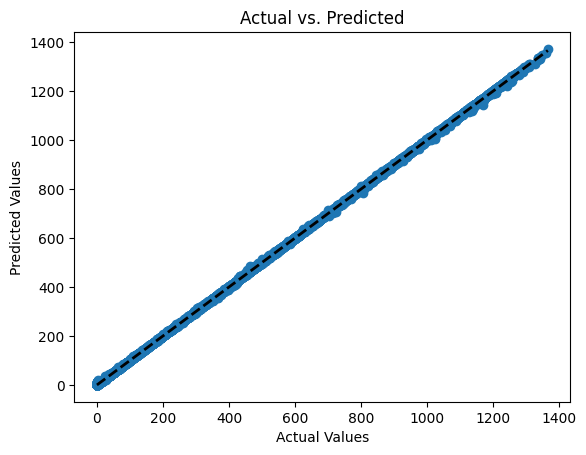

In [109]:
import matplotlib.pyplot as plt

# I think i fucked up here at predictios

plt.scatter(Y_test_cls, predictions)
plt.plot([Y_test_cls.min(), Y_test_cls.max()], [Y_test_cls.min(), Y_test_cls.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()


In [110]:

# i probably fucked up here

from sklearn.model_selection import train_test_split

# Define the features (X) and target variable (Y)
#X = df_solar[['DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DC_POWER']]
#Y = df_solar['AC_POWER']

# Split the data into training and testing sets
#X_train_cls remember
X_train, X_test, Y_train, Y_test = train_test_split(X_train_cls, Y_train_cls, test_size=0.2, random_state=42)


In [111]:
X_cls.head()

DAILY_YIELD    TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
0     9425.000    2429011.000               27.005              25.061   
1        0.000 1215278736.000               27.005              25.061   
2     3075.333 2247719577.000               27.005              25.061   
3      269.933    1704250.000               27.005              25.061   
4     3177.000   19941526.000               27.005              25.061   

   IRRADIATION  DC_POWER  
0        0.000     0.000  
1        0.000     0.000  
2        0.000     0.000  
3        0.000     0.000  
4        0.000     0.000

In [112]:
Y_cls.head()

0   0.000
1   0.000
2   0.000
3   0.000
4   0.000
Name: AC_POWER, dtype: float64

In [113]:
from sklearn.linear_model import LinearRegression

# Create an instance of the linear regression model
cls_models = LinearRegression()

# Train the model
cls_models.fit(X_train, Y_train)


LinearRegression()

In [114]:
# Generate predictions on the testing set
predictions = cls_models.predict(X_test)


In [115]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(Y_test, predictions)
mae = mean_absolute_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)


Mean Squared Error: 0.8083235801883166
Mean Absolute Error: 0.6066030453063957
R-squared: 0.9999938922161602


In [116]:
print(predictions)

[2.41757636e-01 1.16265852e+03 1.24476940e+03 ... 3.42864453e-02
 1.48793298e-01 1.06553289e+03]


In [117]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(Y_test, predictions)
mae = mean_absolute_error(Y_test, predictions)
r2 = r2_score(Y_test, predictions)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)


Mean Squared Error: 0.8083235801883166
Mean Absolute Error: 0.6066030453063957
R-squared: 0.9999938922161602


In [118]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_test_cls,Y_test_cls, test_size=0.2, random_state=42)

# Create and train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model using R-squared score
R2_Score_lr = round(r2_score(y_test, y_pred_lr) * 100, 2)

print("R2 Score: ", R2_Score_lr, "%")


R2 Score:  100.0 %


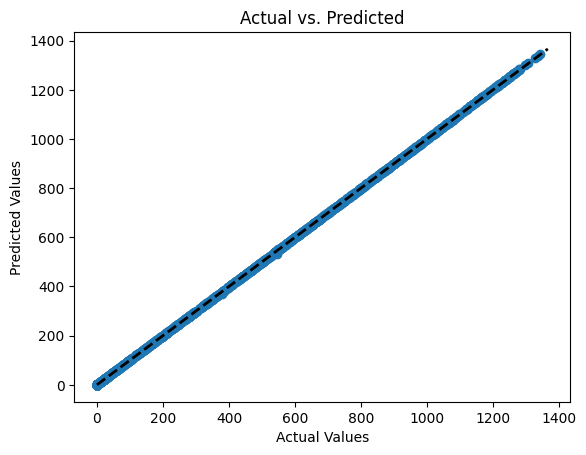

In [119]:

plt.scatter(y_test, y_pred_lr)
plt.plot([Y_test_cls.min(), Y_test_cls.max()], [Y_test_cls.min(), Y_test_cls.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

In [120]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X_train_cls, Y_train_cls)
y_pred_rfr = rfr.predict(X_test_cls)
R2_Score_rfr = round(r2_score(Y_test_cls, y_pred_rfr) * 100, 2)

print("R2 Score:", R2_Score_rfr, "%")


R2 Score: 100.0 %


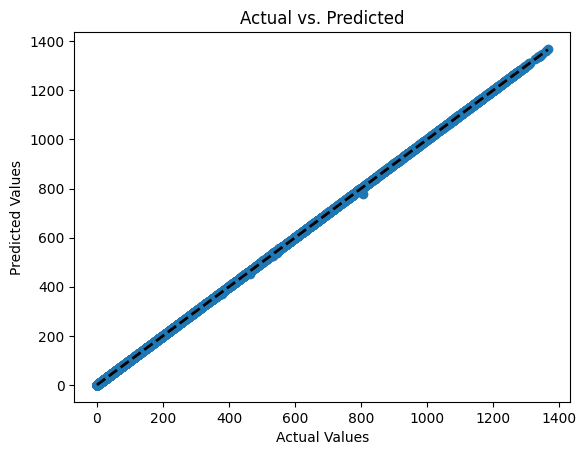

In [121]:


plt.scatter(Y_test_cls, y_pred_rfr)
plt.plot([Y_test_cls.min(), Y_test_cls.max()], [Y_test_cls.min(), Y_test_cls.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

In [122]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)

y_pred_dtr = dtr.predict(X_test)
R2_Score_dtr = round(r2_score(y_test, y_pred_dtr) * 100, 2)

print("R2 Score:", R2_Score_dtr, "%")


R2 Score: 100.0 %


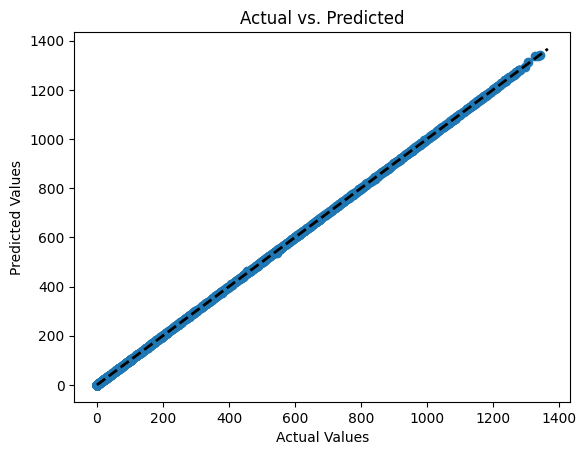

In [123]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_dtr)
plt.plot([Y_test_cls.min(), Y_test_cls.max()], [Y_test_cls.min(), Y_test_cls.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.show()

In [124]:
prediction = rfr.predict(X_test)
print(prediction)

[  0.          59.55089597 551.71261429 ...   0.           0.
 196.04093808]


In [125]:
cross_checking = pd.DataFrame({'Actual' : y_test , 'Predicted' : prediction})
cross_checking.head()

Actual  Predicted
22088   0.000      0.000
54000  59.777     59.551
62312 551.840    551.713
61210   0.000      0.000
8075    0.000      0.000

In [126]:
cross_checking['Error'] = cross_checking['Actual'] - cross_checking['Predicted']
cross_checking.head()

Actual  Predicted  Error
22088   0.000      0.000  0.000
54000  59.777     59.551  0.226
62312 551.840    551.713  0.127
61210   0.000      0.000  0.000
8075    0.000      0.000  0.000

In [127]:
cross_checking_final  = cross_checking[cross_checking['Error'] <= 20]
cross_checking_final.sample(25).style.background_gradient(
        cmap='coolwarm').set_properties(**{
            'font-family': 'Lucida Calligraphy',
            'color': 'LigntGreen',
            'font-size': '15px'
        })
